In [18]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [20]:
!unzip -q /content/drive/My\ Drive/Clean_and_dirty_plates/plates.zip -d plates

In [21]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [22]:
!ls plates

plates


In [23]:
import pickle
import numpy as np
from skimage import io
import os
import random

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
import torch

from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [24]:
def SEED_EVERYTHING(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.random.initial_seed()

In [25]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")
SEED_EVERYTHING(7)

In [26]:
class PlateDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        if self.mode != 'train':
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
          ])
        else:
            transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomChoice(
                                  [
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(180)]),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
          ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [27]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [28]:
TRAIN_DIR = Path('plates/plates/train') 
TEST_DIR = Path('plates/plates/test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [29]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [30]:
val_dataset = PlateDataset(val_files, mode='val')

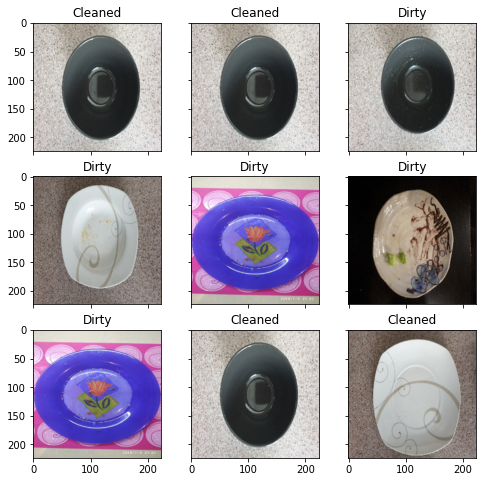

In [31]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,10))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [32]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [33]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [34]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    print(train_loader)
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size = 15, gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            scheduler.step()
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [35]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

             
    probs = torch.nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [36]:
train_dataset = PlateDataset(train_files, mode='train')

In [37]:
from torchvision import models


In [38]:
import torchvision

In [39]:
model = models.resnet50(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False


model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)



Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [40]:
print(len(train_dataset))

30


In [41]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

epoch:   0%|          | 0/10 [00:00<?, ?it/s]


FOLD 1
loss 0.6965319789372958


epoch:  10%|█         | 1/10 [00:00<00:06,  1.35it/s]


Epoch 001 train_loss: 0.6965     val_loss 0.6818 train_acc 0.5769 val_acc 0.5714
loss 0.6259779907189883


epoch:  20%|██        | 2/10 [00:01<00:05,  1.45it/s]


Epoch 002 train_loss: 0.6260     val_loss 0.6978 train_acc 0.6154 val_acc 0.5000
loss 0.5370812232677753


epoch:  30%|███       | 3/10 [00:01<00:04,  1.53it/s]


Epoch 003 train_loss: 0.5371     val_loss 0.6619 train_acc 0.7692 val_acc 0.6429


loss 0.5570967185955781


epoch:  40%|████      | 4/10 [00:02<00:03,  1.59it/s]


Epoch 004 train_loss: 0.5571     val_loss 0.6852 train_acc 0.7692 val_acc 0.5000
loss 0.40420450957921833


epoch:  50%|█████     | 5/10 [00:03<00:03,  1.62it/s]


Epoch 005 train_loss: 0.4042     val_loss 0.6734 train_acc 0.9231 val_acc 0.6429


epoch:  60%|██████    | 6/10 [00:03<00:02,  1.68it/s]

loss 0.39891592585123503

Epoch 006 train_loss: 0.3989     val_loss 0.7124 train_acc 0.9231 val_acc 0.6429


epoch:  70%|███████   | 7/10 [00:04<00:01,  1.72it/s]

loss 0.3990002033802179


epoch:  70%|███████   | 7/10 [00:04<00:01,  1.72it/s]


Epoch 007 train_loss: 0.3990     val_loss 0.6932 train_acc 0.7692 val_acc 0.6429


epoch:  80%|████████  | 8/10 [00:04<00:01,  1.74it/s]

loss 0.279910323711542


epoch:  80%|████████  | 8/10 [00:04<00:01,  1.74it/s]


Epoch 008 train_loss: 0.2799     val_loss 0.6909 train_acc 1.0000 val_acc 0.5000


epoch:  90%|█████████ | 9/10 [00:05<00:00,  1.75it/s]

loss 0.2991027866418545


epoch:  90%|█████████ | 9/10 [00:05<00:00,  1.75it/s]


Epoch 009 train_loss: 0.2991     val_loss 0.7188 train_acc 0.8846 val_acc 0.5000


epoch: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

loss 0.2896049916744232


epoch: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]



Epoch 010 train_loss: 0.2896     val_loss 0.7106 train_acc 0.8846 val_acc 0.5000


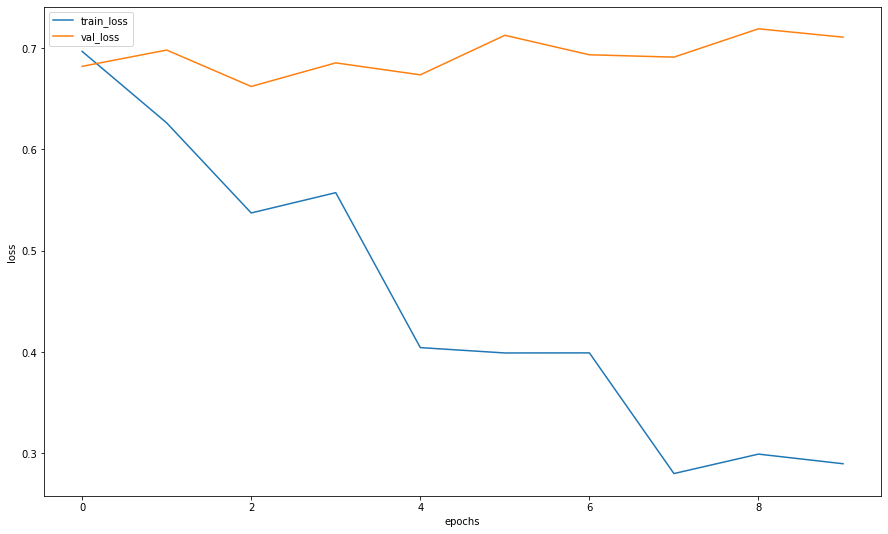

epoch:   0%|          | 0/10 [00:00<?, ?it/s]


FOLD 2


epoch:  10%|█         | 1/10 [00:00<00:04,  1.87it/s]

loss 0.46167999505996704

Epoch 001 train_loss: 0.4617     val_loss 0.2035 train_acc 0.8148 val_acc 0.9231


epoch:  20%|██        | 2/10 [00:01<00:04,  1.86it/s]

loss 0.4889627893765767

Epoch 002 train_loss: 0.4890     val_loss 0.1876 train_acc 0.7037 val_acc 0.9231


epoch:  30%|███       | 3/10 [00:01<00:03,  1.84it/s]

loss 0.40013163950708175

Epoch 003 train_loss: 0.4001     val_loss 0.2223 train_acc 0.8519 val_acc 1.0000


epoch:  40%|████      | 4/10 [00:02<00:03,  1.84it/s]

loss 0.39011290007167393

Epoch 004 train_loss: 0.3901     val_loss 0.2863 train_acc 0.9259 val_acc 0.9231


epoch:  50%|█████     | 5/10 [00:02<00:02,  1.85it/s]

loss 0.41935600174797905

Epoch 005 train_loss: 0.4194     val_loss 0.2126 train_acc 0.8519 val_acc 1.0000


epoch:  60%|██████    | 6/10 [00:03<00:02,  1.82it/s]

loss 0.3298107749885983

Epoch 006 train_loss: 0.3298     val_loss 0.1868 train_acc 0.9259 val_acc 0.9231


epoch:  70%|███████   | 7/10 [00:03<00:01,  1.83it/s]

loss 0.361210521724489

Epoch 007 train_loss: 0.3612     val_loss 0.1957 train_acc 0.9259 val_acc 0.9231


epoch:  80%|████████  | 8/10 [00:04<00:01,  1.84it/s]

loss 0.37583890226152206

Epoch 008 train_loss: 0.3758     val_loss 0.1858 train_acc 0.7778 val_acc 0.9231


epoch:  90%|█████████ | 9/10 [00:04<00:00,  1.83it/s]

loss 0.2680063413249122

Epoch 009 train_loss: 0.2680     val_loss 0.2436 train_acc 0.9259 val_acc 1.0000


epoch: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]

loss 0.31119969652758706

Epoch 010 train_loss: 0.3112     val_loss 0.3028 train_acc 0.9259 val_acc 0.9231


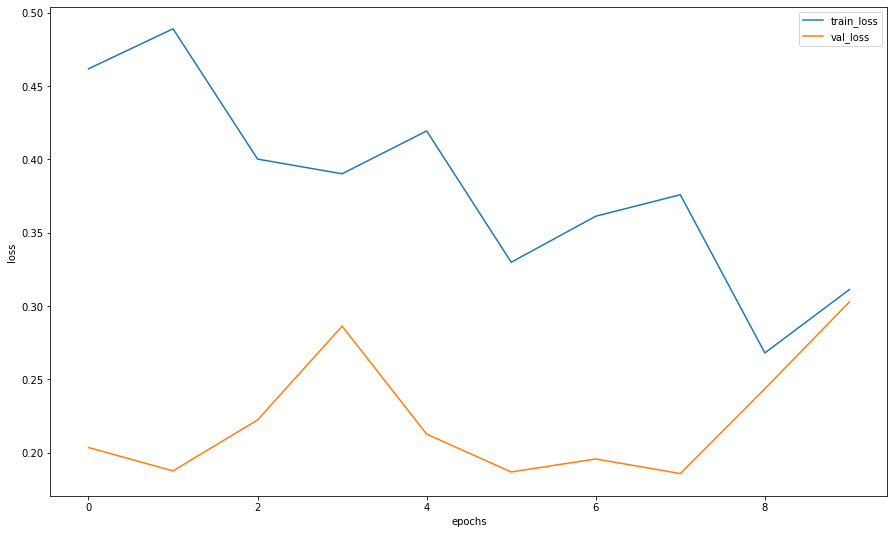

epoch:   0%|          | 0/10 [00:00<?, ?it/s]


FOLD 3


epoch:  10%|█         | 1/10 [00:00<00:04,  1.92it/s]

loss 0.22272134158346388

Epoch 001 train_loss: 0.2227     val_loss 0.4764 train_acc 0.9630 val_acc 0.7692


epoch:  20%|██        | 2/10 [00:01<00:04,  1.89it/s]

loss 0.4749768508805169

Epoch 002 train_loss: 0.4750     val_loss 0.2192 train_acc 0.7778 val_acc 1.0000


epoch:  30%|███       | 3/10 [00:01<00:03,  1.87it/s]

loss 0.27392062544822693

Epoch 003 train_loss: 0.2739     val_loss 0.2321 train_acc 0.8889 val_acc 1.0000


epoch:  40%|████      | 4/10 [00:02<00:03,  1.86it/s]

loss 0.30868877636061776

Epoch 004 train_loss: 0.3087     val_loss 0.2449 train_acc 0.9259 val_acc 1.0000


epoch:  50%|█████     | 5/10 [00:02<00:02,  1.84it/s]

loss 0.3439420759677887

Epoch 005 train_loss: 0.3439     val_loss 0.1908 train_acc 0.8519 val_acc 1.0000


epoch:  60%|██████    | 6/10 [00:03<00:02,  1.85it/s]

loss 0.200822780529658

Epoch 006 train_loss: 0.2008     val_loss 0.2422 train_acc 0.9630 val_acc 0.9231


epoch:  70%|███████   | 7/10 [00:03<00:01,  1.83it/s]

loss 0.31360214948654175

Epoch 007 train_loss: 0.3136     val_loss 0.3040 train_acc 0.9259 val_acc 0.7692


epoch:  80%|████████  | 8/10 [00:04<00:01,  1.83it/s]

loss 0.17935332655906677

Epoch 008 train_loss: 0.1794     val_loss 0.2808 train_acc 0.9630 val_acc 0.9231


epoch:  90%|█████████ | 9/10 [00:04<00:00,  1.84it/s]

loss 0.17281907631291282

Epoch 009 train_loss: 0.1728     val_loss 0.2399 train_acc 1.0000 val_acc 0.9231


epoch: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]

loss 0.18983229332500035

Epoch 010 train_loss: 0.1898     val_loss 0.2119 train_acc 1.0000 val_acc 0.9231


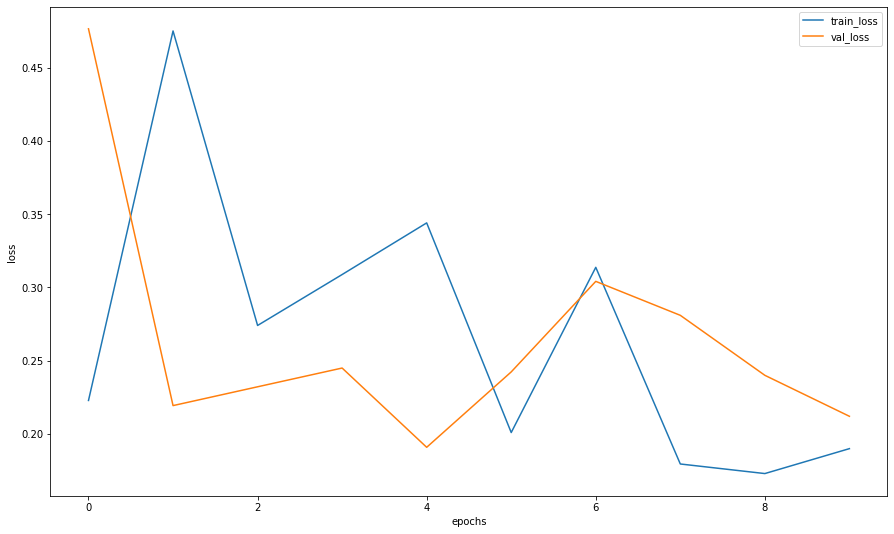

In [42]:
from sklearn.model_selection import StratifiedKFold

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_files, label_encoder.transform(train_val_labels))):
    print('\nFOLD', fold+1)
    val_dataset = PlateDataset(np.array(train_val_files)[val_idx], mode='val')
    train_dataset = PlateDataset(np.array(train_val_files)[train_idx], mode='train')
    
    history = train(train_dataset, val_dataset, model=model, epochs=10, batch_size=15)
    
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    plt.close()

In [ ]:

test_dataset = PlateDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=32)
probs = predict(model, test_loader)



preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd

In [ ]:
submit = pd.DataFrame({'id': test_filenames, 'label': preds})
submit['id'] = submit['id'].str.replace('.jpg', '')
submit.head()

,id,label
0,0000,dirty
1,0001,dirty
2,0002,dirty
3,0003,dirty
4,0004,dirty


In [ ]:
submit.to_csv('Resnet50_folds3_AdamW_sch15_epochs10_batch15.csv', index=False)